In [0]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def error_rate(y, p):
    return np.mean(y != p)

class RBM(object):
    def __init__(self, D, M, id):
        self.id = id
        self.D = D
        self.build(D, M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        self.W = tf.Variable(tf.random_normal(shape=(D, M)))
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(tf.float32, shape=(None,D))

        self.p_h_given_v = tf.nn.sigmoid(tf.matmul(self.X_in, self.W) + self.c)
        r = tf.random_uniform(shape=tf.shape(self.p_h_given_v))
        H = tf.cast(r < self.p_h_given_v, tf.float32)

        p_v_given_h = tf.nn.sigmoid(tf.matmul(H, tf.transpose(self.W)) + self.b)
        r = tf.random_uniform(shape=tf.shape(p_v_given_h))
        X_sample = tf.cast(r < p_v_given_h, tf.float32)

        objective = tf.reduce_mean(self.free_energy(self.X_in)) - tf.reduce_mean(self.free_energy(X_sample))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(objective)

        logits = self.forward_logits(self.X_in)
        self.cost_op = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=self.X_in)
        )

    def fit(self, X, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N//batch_sz

        costs = []
        print('Training RBM ', self.id)
        for i in range(epochs):
            print('epoch ', i, end=' ')
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost_op), feed_dict={self.X_in: batch})
                costs.append(c)
            print('cost: ', c)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def free_energy(self, V):
        b = tf.reshape(self.b, (self.D, 1))
        term1 = -tf.matmul(V, b)
        term1 = tf.reshape(term1, (-1,))

        term2 = tf.reduce_sum(
            tf.nn.softplus(tf.matmul(V, self.W) + self.c)
        )

        return term1-term2

    def forward_hidden(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.b

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

    def transform(self, X):
        return self.session.run(self.p_h_given_v, feed_dict={self.X_in: X})

class DNN(object):
    def __init__(self, D, hidden_layer_sizes, K):
        self.hidden_layers = []
        count = 0
        current_input = D
        for hl_size in hidden_layer_sizes:
            self.hidden_layers.append(RBM(current_input, hl_size, count))
            count += 1
            current_input = hl_size
        self.build_final_layer(D, hidden_layer_sizes[-1], K)

    def set_session(self, session):
        self.session = session

        for ae in self.hidden_layers:
            ae.set_session(session)

    def build_final_layer(self, D, M, K):
        self.W = tf.Variable(tf.random_normal(shape=(M, K)))
        self.b = tf.Variable(np.zeros(K).astype(np.float32))

        self.X = tf.placeholder(tf.float32, shape=(None, D))
        self.Y = tf.placeholder(tf.int32, shape=(None,))
        logits = self.forward(self.X)

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.Y)
        )
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        self.predict_op = tf.argmax(logits, axis=1)

    def fit(self, x_train, y_train, x_test, y_test, epochs=1, batch_sz=100, show_fig=True):
        current_input = x_train
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=2, show_fig=False)
            current_input = ae.transform(current_input)
        
        N, D = x_train.shape
        n_batches = N//batch_sz

        costs = []
        print('supervised training: ')
        for i in range(epochs):
            print('epoch ', i+1, end=' ')
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(n_batches):
                x_batch = x_train[j*batch_sz:(j*batch_sz + batch_sz)]
                y_batch = y_train[j*batch_sz:(j*batch_sz + batch_sz)]
                self.session.run(self.train_op, feed_dict={self.X: x_batch, self.Y: y_batch})
                c, p = self.session.run((self.cost, self.predict_op), feed_dict={self.X: x_test, self.Y: y_test})
                costs.append(c)

            print('Cost: ', c, ' Error rate: ', error_rate(p, y_test))

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        return tf.matmul(Z, self.W) + self.b

Training RBM  0
epoch  0 cost:  0.3066849
epoch  1 cost:  0.24038853
Training RBM  1
epoch  0 cost:  0.161838
epoch  1 cost:  0.13094477
Training RBM  2
epoch  0 cost:  0.24630822
epoch  1 cost:  0.20919073
supervised training: 
epoch  1 Cost:  0.9464794  Error rate:  0.224
epoch  2 Cost:  0.7236335  Error rate:  0.18
epoch  3 Cost:  0.6194264  Error rate:  0.161
epoch  4 Cost:  0.5823334  Error rate:  0.151
epoch  5 Cost:  0.5707605  Error rate:  0.144
epoch  6 Cost:  0.5519012  Error rate:  0.137
epoch  7 Cost:  0.56307477  Error rate:  0.134
epoch  8 Cost:  0.5646622  Error rate:  0.131
epoch  9 Cost:  0.5656953  Error rate:  0.132
epoch  10 Cost:  0.5689893  Error rate:  0.134
epoch  11 Cost:  0.57190543  Error rate:  0.134
epoch  12 Cost:  0.5733975  Error rate:  0.132
epoch  13 Cost:  0.5751075  Error rate:  0.134
epoch  14 Cost:  0.5755695  Error rate:  0.135
epoch  15 Cost:  0.5766805  Error rate:  0.135
epoch  16 Cost:  0.5777141  Error rate:  0.137
epoch  17 Cost:  0.5772347 

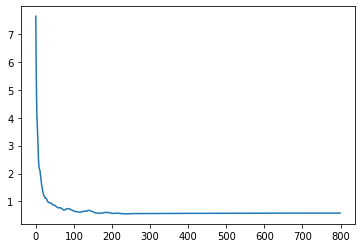

In [30]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test, y_train, y_test = x_train[:4000, :], x_test[:1000, :], y_train[:4000], y_test[:1000]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

D = x_train.shape[1]
K = len(set(y_train))
dnn = DNN(D, [1000, 750, 500], K)

init_op = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init_op)
    dnn.set_session(session)
    dnn.fit(x_train, y_train, x_test, y_test, epochs=20)